# App-ifying 'recovering data from images'

**[TRY THIS INSTEAD](http://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line/37744549#37744549)** 

Requirements:

- `numpy`
- `scipy`
- `scikit-learn`
- `pillow`

I recommend installing them with `conda install`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Make an image

Make some fake data in the closed interval [0,1] and apply a colourmap.

In [2]:
import networkx as nx

In [3]:
from scipy import signal

In [6]:
nx, ny = 100, 100
z = np.random.rand(nx, ny)

sizex, sizey = 30, 30
x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
f = g/g.sum()

z = signal.convolve(z, f, mode='valid')
z = (z - z.min())/(z.max() - z.min())

In [7]:
cd ~/Dropbox/dev/rainbow/notebooks

/Users/matt/Dropbox/dev/rainbow/notebooks


In [8]:
cmap = 'viridis'    # Perceptual
cmap = 'spectral'   # Classic rainbow
cmap = 'seismic'    # Classic diverging
cmap = 'Accent'     # Needs coolinearity constraint
cmap = 'Dark2'      # Needs coolinearity constraint
cmap = 'Paired'     # Needs coolinearity constraint, ultimate test!
cmap = 'gist_ncar'  # Works with new cool-point start location
cmap = 'Pastel1'    # Amazing that it works for start point
cmap = 'Set2'       # Difficult

cmap = 'Dark2'

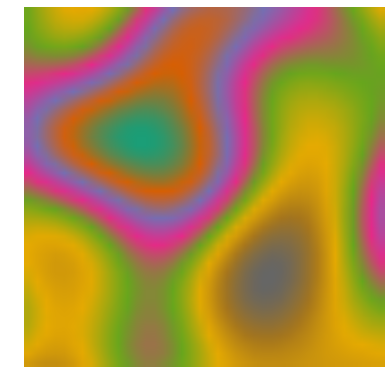

In [9]:
fig = plt.figure(frameon=False)
fig.set_size_inches(5,5)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# Note: interpolation introduces new colours.
plt.imshow(z, cmap=cmap, aspect='auto')
#plt.imshow(z, cmap=cmap, interpolation='none')

fig.savefig('data/cbar/test.png')

In [10]:
cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]

In [11]:
# fig, axes = plt.subplots(24, 6, figsize=(10, 7))
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1,
#                     hspace=0.1, wspace=0.1)

# im = np.outer(np.ones(10), np.arange(100))

# cmaps = [m for m in plt.cm.datad if not m.endswith("_r")]
# cmaps.sort()

# axes = axes.T.ravel()
# for ax in axes:
#     ax.axis('off')

# for cmap, color_ax, null_ax in zip(cmaps, axes[1::2], axes[2::2]):
#     del null_ax
#     color_ax.set_title(cmap, fontsize=10)
#     color_ax.imshow(im, cmap=cmap)

## Read an image

In [12]:
cd ~/Dropbox/dev/rainbow/notebooks

/Users/matt/Dropbox/dev/rainbow/notebooks


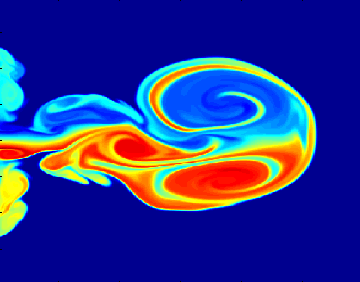

In [19]:
from PIL import Image

# img = Image.open('data/cbar/boxer.png')
img = Image.open('data/cbar/fluid.png')
# img = Image.open('data/cbar/lisa.png')
#img = Image.open('data/cbar/redblu.png')
#img = Image.open('data/cbar/seismic.png')
#img = Image.open('data/cbar/drainage.jpg')
#img = Image.open('data/cbar/test.png')

#img = Image.open('data/cbar/Colormap_Jet1.png')

img

In [20]:
img.size

(360, 282)

Instead of taking a random sample, let's take all pixels from a smaller version of the image.

In [21]:
# def resize_if_necessary(img, max_size=256):
#     h, w = img.size
#     if h * w > max_size**2:
#         img = img.resize((max_size, max_size))
#     return img

In [22]:
# img_sm = resize_if_necessary(img)

Cast as an array, and ignore the last channel (alpha), if there is one.

## Quantize with scikit

In [23]:
n_colours = 100

In [24]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [25]:
im = np.asarray(img)[..., :3] / 255.

h, w, d = im.shape
im_ = im.reshape((w * h, d))

# Define training set.
n = min(h*w//50, n_colours*10)
sample = shuffle(im_, random_state=0)[:n]

In [26]:
print("Sampled {} pixels".format(n))

Sampled 1000 pixels


Train:

In [27]:
kmeans = KMeans(n_clusters=n_colours).fit(sample)

Now I can make an RGB palette `p` — also known as a codebook in information theory terms:

In [83]:
p = kmeans.cluster_centers_

# I don't know why I need to do this, but I do. Floating point precision maybe.
p[p > 1] = 1
p[p < 0] = 0

The only problem with this `p` is that it is not in order — that it, there cluster centres are more or less randomly arranged. We will fix that in the next section.

The vector `p` is actually all we need, but if you want to see what the quantized image looks like, carry on:

In [84]:
# labels = kmeans.predict(im_)

# def recreate_image(palette, labels, h, w):
#     image = np.zeros((h, w, palette.shape[1]))
#     label_idx = 0
#     for i in range(h):
#         for j in range(w):
#             image[i][j] = palette[labels[label_idx]]
#             label_idx += 1
#     return image

# q = recreate_image(p, labels, h, w)

# plt.imshow(q)
# plt.show()

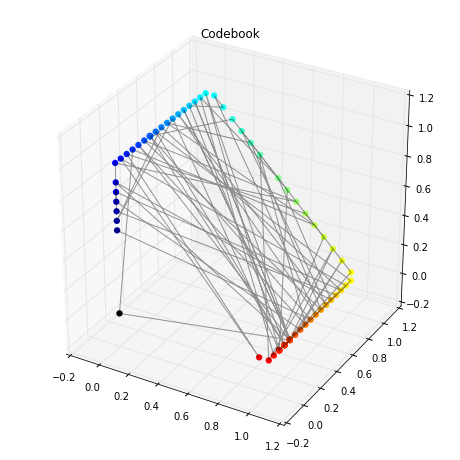

In [85]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*p.T, c=p, lw=0, s=40, alpha=1)
ax.plot(*p.T, color='k', alpha=0.4)
ax.set_title('Codebook')

plt.show()

## Travelling salesman problem

Remember that these points are essentially in random order:

In [86]:
from sklearn.neighbors import BallTree

def mask_colours(a, colours, tolerance=1e-3, leave=0):
    tree = BallTree(a)
    target = tree.query_radius(colours, tolerance)
    mask = np.ones(a.shape[0], dtype=bool)
    end = None if leave < 2 else 1 - leave
    for t in target:
        mask[t[leave:end]] = False
    return a[mask]

def remove_duplicates(a, tolerance=1e-3):
    for c in a:
        a = mask_colours(a, [c], leave=1)
    return a

In [87]:
newp = remove_duplicates(p)

In [88]:
newp = mask_colours(newp, [[1,1,1], [0,0,0]])

In [89]:
p = np.vstack([[[0, 0, 0.5]], newp])

In [90]:
from sklearn.neighbors import NearestNeighbors

clf = NearestNeighbors(2).fit(p)
G = clf.kneighbors_graph()

In [91]:
import networkx as nx

T = nx.from_scipy_sparse_matrix(G)

In [92]:
path = nx.dfs_preorder_nodes(T, 0)

In [93]:
c = p[list(path)[1:]]

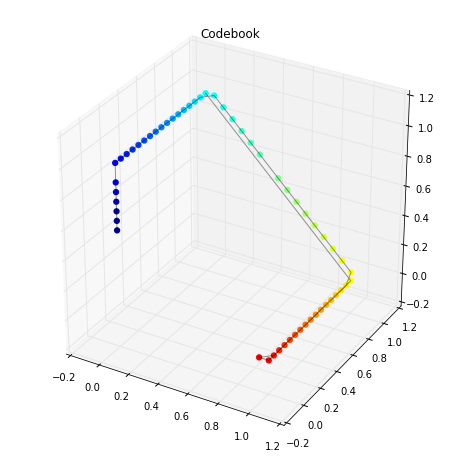

In [95]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax.plot(*c.T, color='k', alpha=0.4)
ax.set_title('Codebook')

plt.show()

** OK That didn't really work **

I propose starting at the dark end (the end of the line nearest black) and crawling aling the line of points from there. This will make a nice organized sequence of codes — in our case, this will be the colourmap.

We can solve this problem as the travelling salesman problem. Find the shortest tour from black (see below) to 'the other end'.

To start with, we need the distances between all points. This is just a norm, but there's a convenient function `scipy.spatial.pdist` for finding distance pairs in *n*-space. Then `squareform` casts it into a square symmetric matrix, which is what we need for our TSP solver.

Other than creating a naive TSP solver in Python – let's face it, it'll be broken or slow or non-optimal — there are three good TSP solver options:

* [LKH](http://www.akira.ruc.dk/~keld/research/LKH/) — [parameter help here](http://webhotel4.ruc.dk/~keld/research/LKH/LKH-2.0/DOC/LKH-2.0_PARAMETERS.pdf).
* [Concorde](http://www.math.uwaterloo.ca/tsp/concorde.html) (I followed [these instructions](http://davidsjohnson.net/TSPcourse/mac-install-concorde.txt) for installing concorde on my Mac.)
* [O-R tools](https://developers.google.com/optimization/routing/tsp)

LKH and Concorde can be used via [the TSP Python package](https://github.com/perrygeo/pytsp) (but note that it used to be called `pyconcorde` so you need to change the names of some functions — look at the source or use [my fork](https://github.com/kwinkunks/pytsp).

Note that you need to add the Concorde and LKH libs to PATH as mentioned in the docs for `pytsp`.

In [31]:
from pytsp import run, dumps_matrix

We need to start the traversal of the locus somewhere.

Poosible heuristics:

* At the end nearest black: we tend to map darker colours to lower values.
* At the cool end: we tend to map cool colours.
* At the apparent start of the line. We might be able to guess where it is: the ends of the line should be the only two points for which the second-closest point is roughly twice as far away as the very closest point. Most points have two points about the same distance away (one on either side). So if we figure out the median (say) smallest non-zero point distance, we can make this estimate.

Blending the first two ideas, I am now starting at (0.25, 0, 0.5). It's the cool-point. (Only 0.25 red because if it's a toss-up between blue and red, I want blue.)

If I include the third idea — choose the dark-bluest end-point candidate — I think it should do better than it is now.

### Using a dark-blue-magenta end point

Aaaanyway, Adding this point allows us to start the TSP there, because it will move to the next nearest point — I think. We will remove it later.

Add cool-point to `p`:

In [32]:
p = np.vstack([[[0.25, 0, 0.5]], p])
#p = np.vstack([[[0, 0, 0]], p])

In [33]:
p[:6]

array([[  2.50000000e-01,   0.00000000e+00,   5.00000000e-01],
       [  1.55431223e-15,   0.00000000e+00,   5.60784314e-01],
       [  1.00000000e+00,   4.98039216e-01,   0.00000000e+00],
       [  0.00000000e+00,   3.72549020e-01,   1.00000000e+00],
       [  1.84313725e-01,   1.00000000e+00,   8.74509804e-01],
       [  8.11764706e-01,   1.00000000e+00,   2.47058824e-01]])

Remember that these points are essentially in random order. We are going to solve the find the shortest Hamiltonian path to organize them.

To do this, we need weights for the edges — and we'll use the distances between the points. There's a convenient function, `scipy.spatial.pdist` for finding distances in *n*-space. We will use the 2-norm, but [the `pdist` function](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) has a great many other metrics.

The convenience function `squareform` organizes the distances into a matrix.

In [34]:
from scipy.spatial.distance import pdist, squareform

# Make distance matrix.
dists = squareform(pdist(p, 'euclidean'))

# The values in `dists` are floats in the range 0 to sqrt(3). 
# Normalize the values to int16s.
d = 32767 * dists / np.sqrt(3)
d = d.astype(np.int16)

# To use a TSP algo to solve the shortest Hamiltonian path problem,
# we need to add a point that is zero units from every other point.
row, col = dists.shape
d = np.insert(d, row, 0, axis=0)
d = np.insert(d, col, 0, axis=1)

The zero-point trick is legit. [Reference](http://stackoverflow.com/questions/6733999/what-is-the-problem-name-for-traveling-salesman-problemtsp-without-considering) from E. L. Lawler, Jan Karel Lenstra, A. H. G. Rinnooy Kan, D. B. Shmoys (1985). The Traveling Salesman Problem: A Guided Tour of Combinatorial Optimization, 1st Edition. Wiley. 476 pp. ISBN 978-0471904137.

In [35]:
d

array([[    0,  4867, 19482, ..., 12708, 12708,     0],
       [ 4867,     0, 23647, ..., 10895, 10895,     0],
       [19482, 23647,     0, ..., 26859, 26859,     0],
       ..., 
       [12708, 10895, 26859, ...,     0,     0,     0],
       [12708, 10895, 26859, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int16)

LKH implementation.

K. Helsgaun (2009). General k-opt submoves for the Lin-Kernighan TSP heuristic. Mathematical Programming Computation, 2009, doi: 10.1007/s12532-009-0004-6.

In [36]:
outf = "/tmp/myroute_lkh.tsp"
with open(outf, 'w') as f:
    f.write(dumps_matrix(d, name="My Route"))

In [37]:
tour_lkh = run(outf, start=0, solver="LKH")

In [38]:
#result = np.array(tour_concorde['tour'])
result = np.array(tour_lkh['tour'])

In [39]:
result

array([  0,   1,  47,  23,  51,  50,  10,  22,  54,  56,  15,  28,  20,
        93,  99,  95,  94,  96,  97,   3, 100,  98,  35,  48,  17,  46,
        41,  12,  37,  67,   7,  63,  39,  38,   4,  43,  18,  30,   8,
        44,  21,  57,  16,   5,  32,  26,  58,  34,  53,  49,  24,   9,
        42,  19,  40,   2,  29,  52,  25,  81,  11,  69,  78,  59,  68,
        62,  72,  80,  66,  75,  73,  33,  76,  77,  61,  13,  82,  27,
        60,  36,  88,  92,  84,  86,  89,  91,  83,  90,  87,  85,  79,
        65,  71,  64,  74,  45,  70,   6,  31,  55, 101,  14])

In [40]:
result.size  # Should be n_colours + 2

102

In [41]:
# e = np.asscalar(np.where(result == result.size-1)[0])

# if e == 1:
#     # Then it's second and I think I know why.
#     # As long as it went to the last point next, and I think
#     # it necessarily does, then we're good.
#     print("Zero-point is second. Probably dealt with it.")
#     result = np.concatenate([result[:e], result[e+1::][::-1]])
# elif e == len(result)-1:
#     # Then it's at the end already.
#     print("Zero-point is at the end. Dealt with it.")
#     result = result[:-1]
# else:
#     # I'm not sure why this would happen... but I Think in this
#     # case we can just skip it.
#     print("Zero-point is somewhere weird. Maybe dealt with... BE CAREFUL.")
#     result = result[result != result.size-1]
    
# assert len(result) == len(p)

Now `result` is the indices of points for the shortest path, shape `(256,)`. And `p` is our quantized colormap, shape `(256, 3)`. So we can select the points easily for an ordered colourmap.

The offsets are to account for the fact that we added a dark-blue point at the start and a zero point at the end.

In [42]:
c = p[result[1:-1]]

IndexError: index 101 is out of bounds for axis 0 with size 101

Ideally I'd like all the distances too, but it wouldn't be too hard to compute these.

Now let's look at it all.

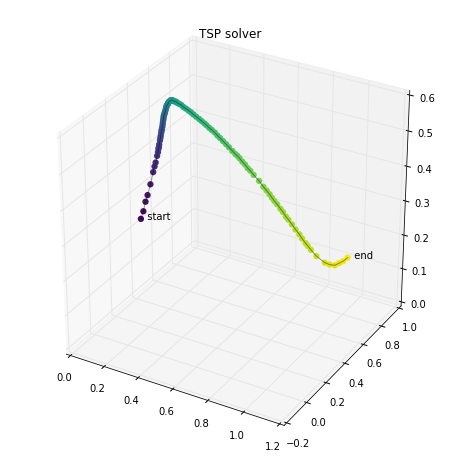

In [308]:
from mpl_toolkits.mplot3d import Axes3D
# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax.plot(*c.T, color='k', alpha=0.4)
ax.text(*c[0], '  start')
ax.text(*c[-1], '  end')
ax.set_title('TSP solver')

plt.show()

Check below an interactive version of the 3D plot. May help when there are complicated paths between points. You need to install plotly and colorlover (with pip) if you don't already have them.

In [309]:
import plotly.graph_objs as go
import colorlover as cl
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

cb = cl.to_rgb(tuple(map(tuple, c*255)))
trace = go.Scatter3d(
        name='TSP Sover',
        x = c[:,0], y = c[:,1], z = c[:,2],
        marker = dict(
            size=4.,
            color=cb
        ),
        line=dict(
            color='#000',
            width=1,
        ),
        )
data = [trace]

# Set the different layout properties of the figure:
layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    margin = dict(
        t=0,b=0,l=0,r=0
    ),
    scene = go.Scene(
        xaxis=dict(
            title='red',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 0, 0)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='green',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(0, 255, 0)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='blue',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(0, 0, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectmode='cube',
        camera=dict( 
            eye=dict(
                x=1.7,
                y=-1.7,
                z=1,
            )
        ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [310]:
np.save('/Users/matt/Dropbox/public/raw_data.npy', p[1:])
np.save('/Users/matt/Dropbox/public/ordered_data.npy', c)

In [311]:
from scipy.spatial import cKDTree

kdtree = cKDTree(c)

In [312]:
dx, ix = kdtree.query(im)

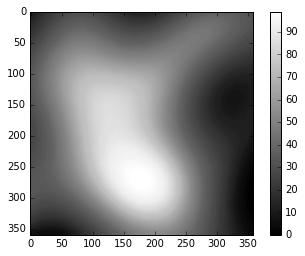

In [313]:
plt.imshow(ix, cmap='gray')
plt.colorbar()
plt.show()

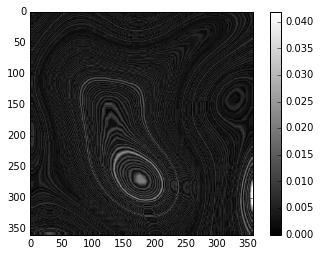

In [314]:
plt.imshow(dx, cmap='gray')
plt.colorbar()
plt.show()

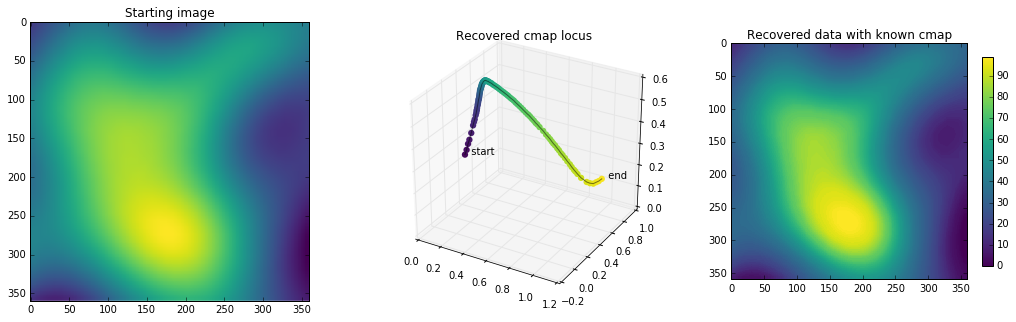

In [315]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im, interpolation='none')
ax0.set_title("Starting image")

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax1.plot(*c.T, color='k', alpha=0.5)
ax1.text(*c[0], '  start')
ax1.text(*c[-1], '  end')
ax1.set_title("Recovered cmap locus")

ax2 = fig.add_subplot(133)
plt.imshow(ix, cmap=cmap, interpolation='none')
plt.colorbar(shrink=0.75)
ax2.set_title("Recovered data with known cmap")

plt.show()

In [316]:
cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]

## Recover the colourbar

In [317]:
# setting up color arrays
r1 = np.array(c)[:, 0] # value of Red for the nth sample
g1 = np.array(c)[:, 1] # value of Green for the nth sample
b1 = np.array(c)[:, 2] # value of Blue for the nth sample

r2 = r1 # value of Red at the nth sample
r0 = np.linspace(0, 1, len(r1)) # position of the nth Red sample within the range 0 to 1

g2 = g1 # value of Green at the nth sample
g0 = np.linspace(0, 1, len(g1)) # position of the nth Green sample within the range 0 to 1

b2 = b1 # value of Blue at the nth sample
b0 = np.linspace(0, 1, len(b1)) # position of the nth Blue sample within the range 0 to 1

# creating lists
R = zip(r0, r1, r2)
G = zip(g0, g1, g2)
B = zip(b0, b1, b2)

# creating list of above lists and transposing
RGB = zip(R, G, B)
rgb = zip(*RGB)
#print rgb

# creating dictionary
k = ['red', 'green', 'blue'] # makes list of keys
data_dict = dict(zip(k,rgb)) # makes a dictionary from list of keys and list of values

# Make a colourbar
import matplotlib.colors as clr

found_cmap = clr.LinearSegmentedColormap('my_colourmap', data_dict)

If we render the found data with the found colorbar, it will look perfect, because the colourbar is the codebook that maps the data to the original image.

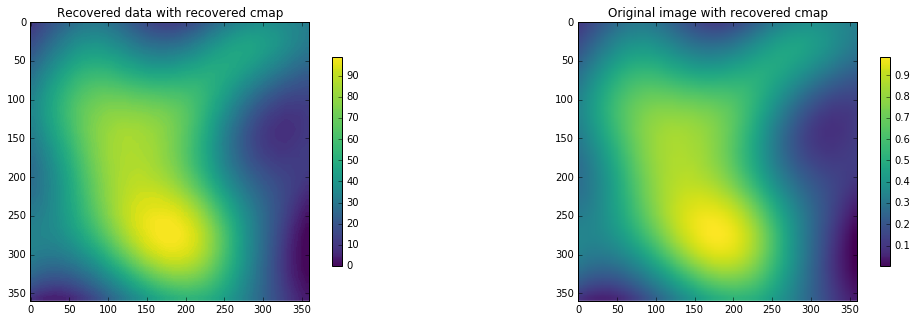

In [318]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(121)
plt.imshow(ix, cmap=found_cmap, interpolation='none')
plt.colorbar(shrink=0.75)
ax0.set_title("Recovered data with recovered cmap")

ax1 = fig.add_subplot(122)
plt.imshow(im, cmap=found_cmap, interpolation='none')
plt.colorbar(shrink=0.75)
ax1.set_title("Original image with recovered cmap")

plt.show()

## Compare the result to what we started with

This only makes sense for the synthetic data, not the test images.

Scale to [0,1] and compare to `z`.

In [319]:
z_out = ix.astype(np.float)
z_out /= np.amax(z_out)

In [320]:
z.shape, z_out.shape

((40, 40), (360, 360))

The original data, `z`, is a different shape. At the risk of distorting it, let's resize it.

In [321]:
from scipy.misc import imresize

z_ = imresize(z, z_out.shape) / 255

In [322]:
diff = z_ - z_out

In [323]:
def rms(a):
    return np.sqrt(np.sum(a**2)/a.size)

print("RMS difference: {:.4f}".format(rms(diff)))

RMS difference: 0.0882


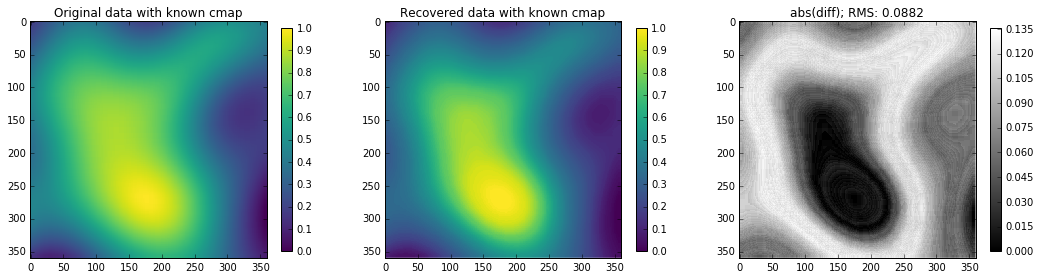

In [324]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131)
plt.imshow(z_, cmap=cmap)
plt.colorbar(shrink=0.8)
ax1.set_title("Original data with known cmap")

ax2 = fig.add_subplot(132)
plt.imshow(z_out, cmap=cmap, interpolation='none')
plt.colorbar(shrink=0.8)
ax2.set_title("Recovered data with known cmap")

ax3 = fig.add_subplot(133)
plt.imshow(abs(diff), interpolation='none', cmap='gray')
plt.colorbar(shrink=0.8)
ax3.set_title("abs(diff); RMS: {:.4f}".format(rms(diff)))

plt.show()

In [325]:
cd ~/Dropbox/dev/rainbow/notebooks/

/Users/matt/Dropbox/dev/rainbow/notebooks


In [326]:
from utils import image_to_data

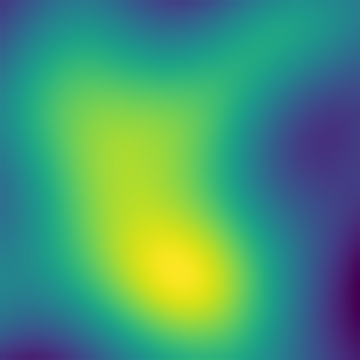

In [327]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

# img = Image.open('data/cbar/boxer.png')
# img = Image.open('data/cbar/fluid.png')
# img = Image.open('data/cbar/lisa.png')
# img = Image.open('data/cbar/redblu.png')
# img = Image.open('data/cbar/seismic.png')
# img = Image.open('data/cbar/drainage.jpg')
img = Image.open('data/cbar/test.png')
img

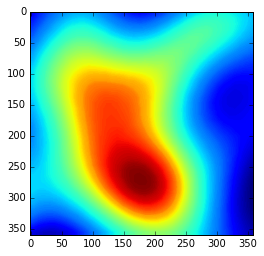

In [328]:
data = image_to_data(img)

plt.imshow(data)
plt.show()

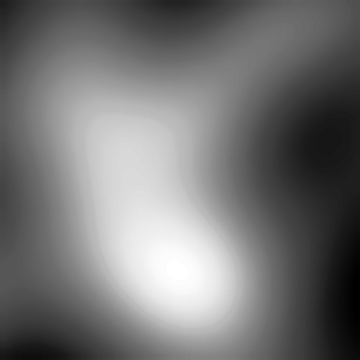

In [329]:
Image.fromarray(np.uint8(data*255))